# Notebook Title

Brief Explanation

## If necessary install pytorch lightning

In [1]:
# !pip install pytorch-lightning

## If you want to use TPU install xla

In [ ]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

## Imports

In [2]:
import torch
from torch import nn
from torch.optim import lr_scheduler

import pytorch_lightning as pl

import torchvision
import torchvision.models as models
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.nn import functional as F
from pytorch_lightning.metrics import Accuracy, Recall, Precision, ROC, AUC

from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

## Configs

In [3]:
TENSORBOARD_DIRECTORY = "logs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Create Pytorch Ligtning Model

In [16]:
class FashionMnistClassifer(pl.LightningModule):
    def __init__(self, batch_size=64):
        super(FashionMnistClassifer, self).__init__()
        
        self.layer_1 = nn.Linear(28*28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)        
        
        self.batch_size = batch_size
        
        self.criterion = F.nll_loss
        self.metrics = {"accuracy": Accuracy(), "recall": Recall()}
    
    def forward(self, x):
        batch_size, channels, width, height = x.size()
        
        x = x.view(batch_size, -1)
        
        x = self.layer_1(x)
        x = torch.relu(x)
        
        x = self.layer_2(x)
        x = torch.relu(x)
        
        x = self.layer_3(x)
        
        return torch.log_softmax(x, dim=1)
    
    
    def prepare_data(self):
        self.trainset = torchvision.datasets.FashionMNIST(
            root = './data/FashionMNIST',
            train = True,
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor()]))

        self.valset = torchvision.datasets.FashionMNIST(
            root = './data/FashionMNIST',
            train = False,
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor()]))
        
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, num_workers=4)
    
    
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size, num_workers=4)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        
        loss = self.criterion(logits, y)

        tensorboard_logs = {'train_loss': loss}
        
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        
        loss = self.criterion(logits, y)
        
        metrics_dict = {f"val_{name}": metric(logits, y) for name, metric in self.metrics.items()}
        
        return {**{"val_loss": loss}, **metrics_dict}
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()

        tensorboard_logs = {name: torch.stack([x[f"val_{name}"] for x in outputs]).mean()
                                for name, metric in self.metrics.items()}
        
        tensorboard_logs["val_loss"] = avg_loss

        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

## Lightning Trainer

In [19]:
logger = TensorBoardLogger(TENSORBOARD_DIRECTORY, name="logger_name")

In [17]:
net = FashionMnistClassifer(batch_size=1024)

In [18]:
trainer = pl.Trainer(max_epochs=10,
                     logger=logger,
                     gpus=0,
                     early_stop_callback=True)

trainer.fit(net)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33 K  
2 | layer_3 | Linear | 2 K   
/home/piotr/anaconda3/envs/medical/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Checkpoint directory logs/logger_name/version_1/checkpoints exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


1

## Add visualizations to Tensorboard

In [20]:
writer = SummaryWriter(TENSORBOARD_DIRECTORY)

valloader = net.val_dataloader()
inputs, labels = next(iter(valloader))
inputs, labels = inputs.to(device), labels.to(device)


In [21]:
grid = torchvision.utils.make_grid(inputs[:25])
writer.add_image('images', grid, 0)

writer.add_graph(net, inputs)
writer.close()

In [22]:
%load_ext tensorboard

In [23]:
# %reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 5521), started 0:10:30 ago. (Use '!kill 5521' to kill it.)

## Show model metrics

In [24]:
net.eval()

final_metrics = {}

for name, metric in net.metrics.items():
        final_metrics[f"{name}"]= torch.stack([metric(net(x), y) for x, y in valloader]).mean()
        
final_metrics

{'accuracy': tensor(0.8654), 'recall': tensor(0.8656)}

## Show Example Predictions

In [25]:
outputs = net(inputs)
predictions = torch.max(outputs, 1)[1]

In [26]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

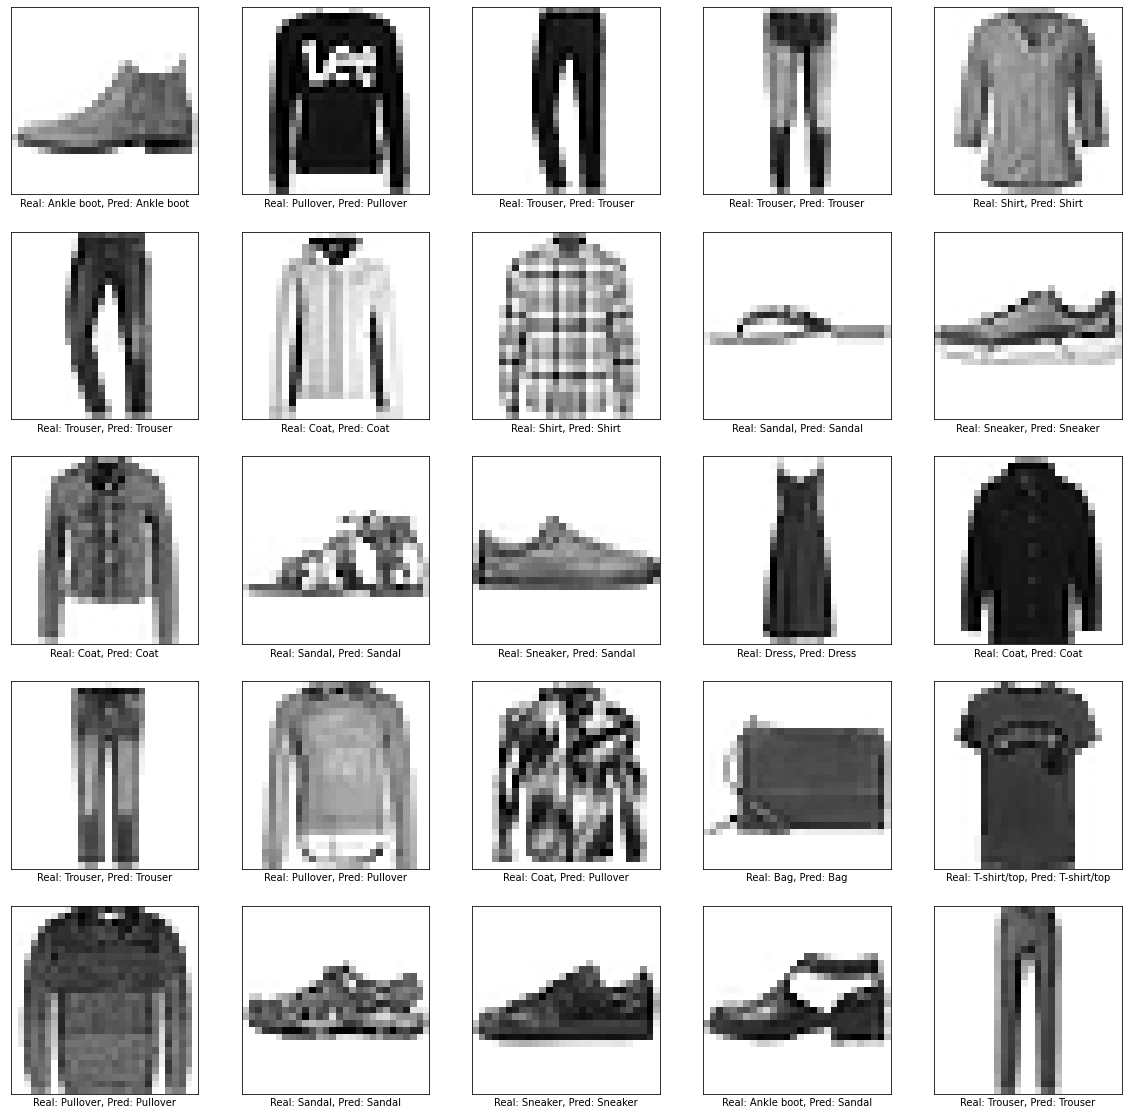

In [27]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(inputs[i].view(28,28), cmap=plt.cm.binary)
    plt.xlabel(f"Real: {class_names[labels[i]]}, Pred: {class_names[predictions[i]]}")
plt.show()